#### This notebook presents how to perform maximum-likelihood parameter estimation for multiple neurons.  The neurons depend on each other through a set of weights.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
%matplotlib inline

In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..'))
sys.path.append(os.path.join(os.getcwd(),'..','code'))
sys.path.append(os.path.join(os.getcwd(),'..','data'))

In [3]:
import filters
import likelihood_functions as lk
import PoissonProcessClasses as PP
import auxiliary_functions as auxfun

In [4]:
import imp
imp.reload(filters)
imp.reload(lk)
imp.reload(auxfun)
imp.reload(PP)


<module 'PoissonProcessClasses' from '/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py'>

In [5]:
# Number of neurons
nofCells = 2

Reading input-output data:

In [6]:
# creating the path to the data
data_path = os.path.join(os.getcwd(),'..','data')

# reading stimulus
Stim = np.array(pd.read_csv(os.path.join(data_path,'Stim.csv'),header = None))

# reading location of spikes
# (lengths of tsp sequences are not equal so reading them line by line)
tsp_list = []
with open(os.path.join(data_path,'tsp2.csv')) as csvfile:
    tspreader = csv.reader(csvfile)
    for row in tspreader:
        tsp_list.append(row)

Extracting a spike train from spike positions:

In [7]:
dt = 0.01
y_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    tsp_int = np.ceil((tsp - dt*0.001)/dt)
    tsp_int = np.reshape(tsp_int,(tsp_int.shape[0],1))
    tsp_int = tsp_int.astype(int)
    y_list.append(np.array([item in tsp_int for item in np.arange(Stim.shape[0]/dt)]).astype(int))

Creating filters:

In [8]:
# create a stimulus filter
kpeaks = np.array([0,round(20/3)])
pars_k = {'neye':5,'n':5,'kpeaks':kpeaks,'b':3}
K,K_orth,kt_domain = filters.createStimulusBasis(pars_k, nkt = 20) 

In [9]:
# create a post-spike filter
hpeaks = np.array([0.1,2])
pars_h = {'n':5,'hpeaks':hpeaks,'b':.4}
H,H_orth,ht_domain = filters.createPostSpikeBasis(pars_h,dt)

Conditional Intensity (spike rate):
$$\lambda_{\beta}(i) = \exp(K(\beta_k)*Stim + H(\beta_h)*y + \sum_{j\ne i}w_j I(\beta_{I})*y_j)$$

$$\lambda_{\beta}(i) = \exp(M_k\beta_k + M_h \beta_h + Y w)$$

Creating a matrix of covariates:

In [10]:
M_k = lk.construct_M_k(Stim,K,dt)

In [11]:
M_h_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    M_h_list.append(lk.construct_M_h(tsp,H_orth,dt,Stim))



In [12]:
# creating a matrix of output covariates
Y = np.array(y_list).T

<!---Simulating a neuron spike trains:-->

In [13]:
M_list = []
for M_h in M_h_list:
    M_list.append(np.hstack((M_k,M_h,Y)))

Conditional intensity as a function of the covariates:
$$ \lambda_{\beta} = \exp(M\beta) $$

Create a Poisson process model with this intensity:

Setting initial parameters:

In [14]:
coeff_k0 = np.array([ 0.061453,0.284916,0.860335,1.256983,0.910615,0.488660,-0.887091,0.097441,0.026607,-0.090147])
coeff_h0 = np.zeros((5,))
coeff_w0 = np.zeros((nofCells,))

pars0 = np.hstack((coeff_k0,coeff_h0,coeff_w0))

Fitting the likelihood:

In [15]:
res_list = []
for i in range(len(y_list)):
    model = PP.PPModel(M_list[i].T,dt = dt)
    res_list.append(model.fit(y_list[i],start_coef = pars0,method = 'Nelder-Mead'))

137.97542958
137.995567537
138.631471405
141.729921607
145.285288398
142.09925536
137.291205084
143.434684692
137.383295462
137.876368268
138.682214615
137.975411123
137.97596092
137.973974607
137.972771917
137.971853583
137.958938853
137.97544167
132.568384937
126.781470961
132.571253681
132.490912316
131.79890048
133.770488957
133.279209776
133.333901152
132.818866826
132.229155888
131.57356269
130.845827831
130.040208908
129.147351435
128.158719455
127.078961575
125.955695439
120.501048438
124.47799833
123.133642729
125.138094127
124.570657225
123.665129624
123.038728407
122.374402114
121.234589025
120.166274329
114.678031259
118.642598031
117.389966332
116.551733567
115.777281005
115.091260959
114.521676623
108.449758381
113.35217029
112.253309952
112.086926083
111.259007371
109.917218169
109.107383979
108.127065225
101.666720038
105.761106988
104.703685271
103.740678834
102.594221996
102.410362141
101.776211894
100.890178788
94.1590318767
99.12395458
97.9938198739
96.5922959432
95

/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:184: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if start_coef==None:
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:358: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:362: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)


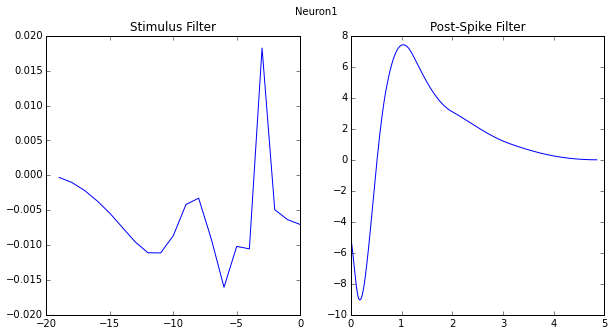

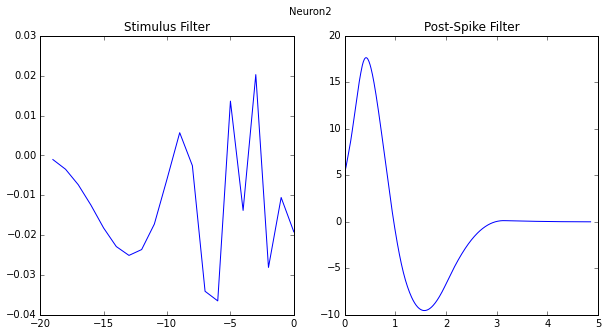

In [16]:
for i in range(len(res_list)):
    k_coeff_predicted = res_list[i].x[:10]
    h_coeff_predicted = res_list[i].x[10:15]
    
    fig,axs = plt.subplots(1,2,figsize = (10,5))
    fig.suptitle('Neuron%d'%(i+1))
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff_predicted))
    axs[0].set_title('Stimulus Filter')
    axs[1].plot(ht_domain,np.dot(H,h_coeff_predicted))
    axs[1].set_title('Post-Spike Filter')

Extracting the weight matrix:

In [17]:
W = np.array([res.x[-2:] for res in res_list])
print(W)

[[  7.5583708   -5.60662017]
 [ -3.31955954  10.29385026]]


Note: the stimulus and the post-spike estimates can be different for different neurons.